In [9]:
import requests
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from init import init
user, api_key = init()

In [10]:
def league_ranking(season, region_code, league_code, output_dir='data/leaguerank'):
    url = f'http://ftc-api.firstinspires.org/v2.0/{season}/leagues/rankings/{region_code}/{league_code}'
    response = requests.get(url, auth=(user, api_key))
    if response.status_code == 200:
        # Parse JSON response
        data = response.json()
        if 'rankings' in data:
            # Convert rankings data to DataFrame
            df = pd.DataFrame(data['rankings'])

            # Define the output file path
            os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
            output_file = os.path.join(output_dir, f'league_rankings_{season}_{region_code}_{league_code}.csv')

            # Save DataFrame to CSV
            df.to_csv(output_file, index=False)
            print(f"Rankings data saved to {output_file}")
            return df
        else:
            print("No 'rankings' key found in the response.")
    else:
        print(f"Failed to fetch data. HTTP status code: {response.status_code}")
        print(f"Response content: {response.text}")

Rankings data saved to data/leaguerank/league_rankings_2024_USNJ_NO.csv
Plot saved to data/leaguerank/east_bergen_rankings.png


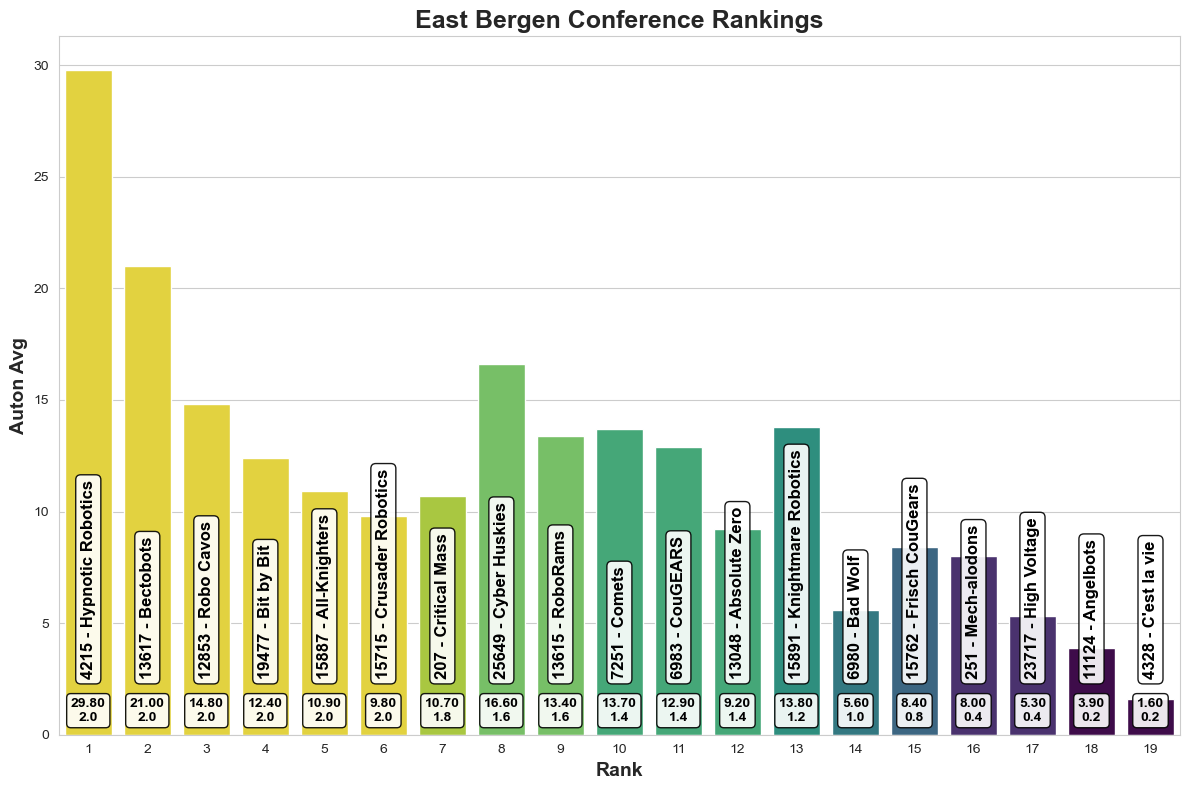

Plot saved to data/leaguerank/far_north_rankings.png


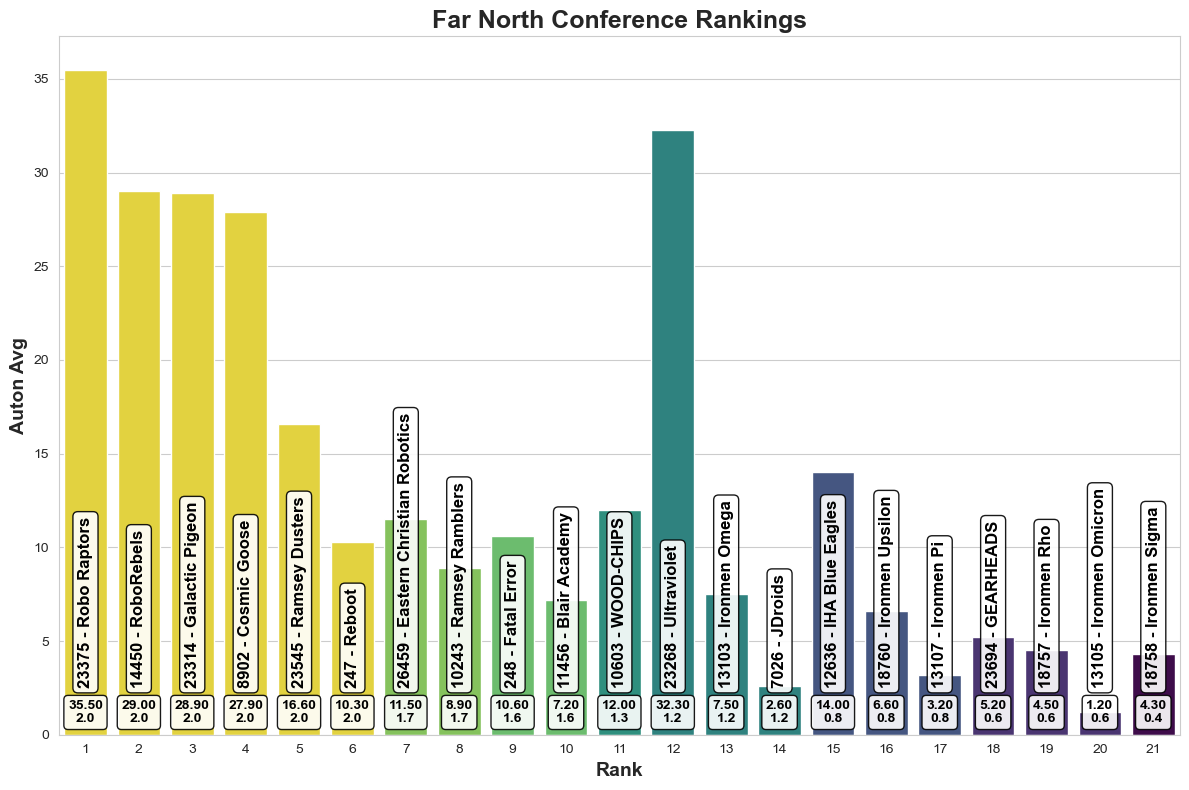

In [11]:
season = '2024'
region_code = 'USNJ'
league_code = 'NO'

# East Bergen and Far North team numbers
east_bergen_teams = [
    207, 251, 4215, 4328, 6980, 6983, 7251, 11124, 12853, 13048, 13615,
    13617, 15715, 15762, 15887, 15891, 19477, 23717, 25649
]
far_north_teams = [
    247, 248, 7026, 8902, 10243, 10603, 11456, 12636, 13103, 13105, 13107,
    14450, 18757, 18758, 18759, 18760, 23268, 23314, 23375, 23545, 23694, 26459
]

df = league_ranking(season, region_code, league_code)

# Assign division rank
df['divisionRank'] = df.groupby(
    df['teamNumber'].apply(lambda x: 'East Bergen' if x in east_bergen_teams else 'Far North')
)['rank'].rank(method='dense').astype(int)

# Filter top 10 teams for each conference
east_bergen_top = df[df['teamNumber'].isin(east_bergen_teams)]  #.nsmallest(10, 'rank')
far_north_top = df[df['teamNumber'].isin(far_north_teams)]  #.nsmallest(10, 'rank')

def create_ar(data, title, filename, output_dir='data/leaguerank'):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=data,
        x='divisionRank',
        y='sortOrder2',
        hue='sortOrder1',
        orient='v',
        palette=sns.color_palette('viridis', as_cmap=True)
    )
    for index, row in data.iterrows():
        ax.text(
            x=row['divisionRank'] - 1,
            y=2.5,
            s=f"{row['teamNumber']} - {row['teamName']}",
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold',
            color='black',
            rotation=90,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.9)
        )
        ax.text(
            x=row['divisionRank'] - 1,
            y=.5,
            s=f"{row['sortOrder2']:.2f}\n{row['sortOrder1']:.1f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='black',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.9)
        )
    ax.legend_.remove()
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Rank', fontsize=14, fontweight='bold')
    plt.ylabel('Auton Avg', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename))
    print(f"Plot saved to {os.path.join(output_dir, filename)}")
    plt.show()


# Create and save the plots
create_ar(east_bergen_top, 'East Bergen Conference Rankings', 'east_bergen_rankings.png')
create_ar(far_north_top, 'Far North Conference Rankings', 'far_north_rankings.png')